#  Projet Machine Learning

### Arthur Frachon - Jeanne Collot

## Sujet

## 1) Problématique 

## 2) Préparation des données

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score,make_scorer
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
warnings.filterwarnings("ignore")

In [2]:
# Charger les fichiers CSV
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)

# Fusionner les cibles avec les features pour exploration
train_data = pd.concat([X_train, y_train], axis=1)

# Vérification des structures des fichiers
print("Structure de nos fichiers : \n")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("\n")

# Exploration initiale des données
print("Informations sur notre dataset : \n")
print(train_data.info())
print("\n --------------------------- \n Informations sur nos features : \n")
print(train_data.describe())

Structure de nos fichiers : 

X_train shape: (10605, 9)
y_train shape: (10605, 1)
X_test shape: (4942, 9)


Informations sur notre dataset : 

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  9318 non-null   float64
 1   coal_power_available           10604 non-null  float64
 2   gas_power_available            10604 non-null  float64
 3   nucelear_power_available       10604 non-null  float64
 4   wind_power_forecasts_average   10581 non-null  float64
 5   solar_power_forecasts_average  10581 non-null  float64
 6   wind_power_forecasts_std       10581 non-null  float64
 7   solar_power_forecasts_std      10581 non-null  float64
 8   predicted_spot_price           1846 non-null   float64
 9   spot_id_delta                  10605 non-nul

## 3) Traitement et création de nouvelles features

### 3.1) Normalisation des données

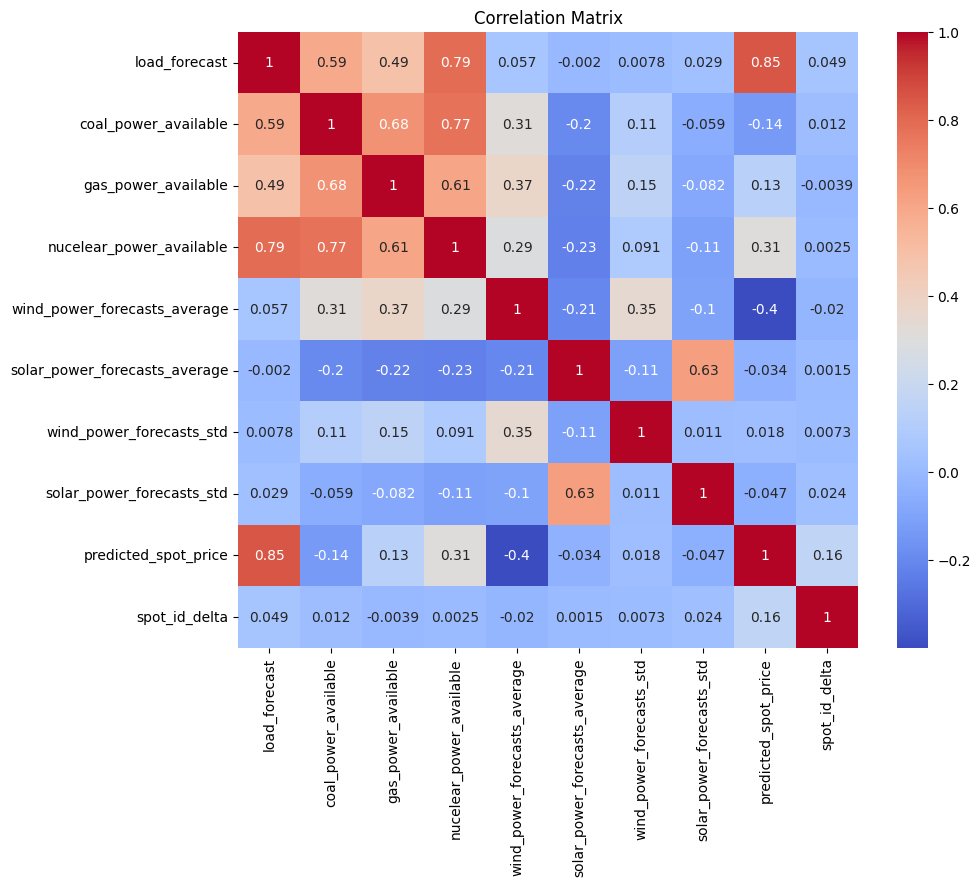

In [3]:
# Vérifier la corrélation entre les features et la cible
corr_matrix = train_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

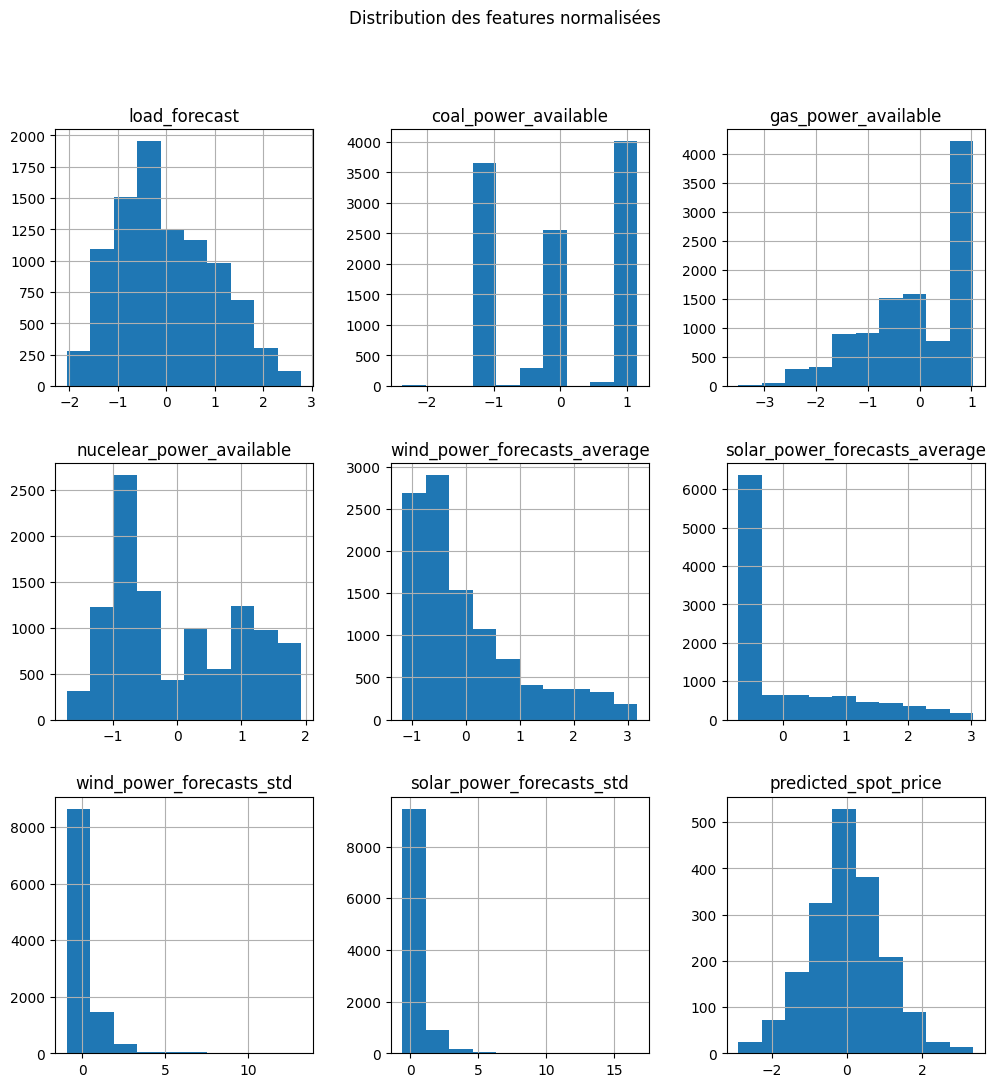

In [4]:
# Normalisation des features numériques
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)

# Vérifier les distributions des features
X_train_scaled.hist(figsize=(12, 12))
plt.suptitle("Distribution des features normalisées")
plt.show()

### 3.2) Méthode 1 - remplissage des valeurs manquantes par la moyenne de la colonne

In [5]:
X_train_1 = X_train_scaled.fillna(X_train_scaled.mean())
print(X_train_1.info())
print(X_train_1.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  10605 non-null  float64
 1   coal_power_available           10605 non-null  float64
 2   gas_power_available            10605 non-null  float64
 3   nucelear_power_available       10605 non-null  float64
 4   wind_power_forecasts_average   10605 non-null  float64
 5   solar_power_forecasts_average  10605 non-null  float64
 6   wind_power_forecasts_std       10605 non-null  float64
 7   solar_power_forecasts_std      10605 non-null  float64
 8   predicted_spot_price           10605 non-null  float64
dtypes: float64(9)
memory usage: 1.1+ MB
None
       load_forecast  coal_power_available  gas_power_available  \
count   1.060500e+04          1.060500e+04         1.060500e+04   
mean   -2.894

In [6]:
X_test_1 = X_test_scaled.fillna(X_test_scaled.mean())
y_train_1 = y_train.copy()

### 3.3) Methode 2 - Calcul des spots prices

Dans un second temps nous testons la 2ème méthode, pour cela nous devons prédire le plus précisemment possible les valeurs spots de l'éléctricité à partir des autres features et des quelques valeurs tests dont nous disposons, nous essaierons plusieurs modèles et garderont celui qui maximise le R².
Nous sommes conscients que cette technique peut ammener à cumuler les erreurs.

Repartons de nos données

#### Traitement des données

In [7]:
# division en set de train et set de test en fonction de si la valeur spot est fournie
data_test = X_train_scaled[X_train_scaled['predicted_spot_price'].isnull()]
data_train = X_train_scaled[~X_train_scaled['predicted_spot_price'].isnull()]
data_train

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2023-01-03 01:00:00+01:00,-0.483443,1.14369,0.995872,0.918269,-0.215268,-0.709050,-0.460626,-0.580229,-0.748258
2023-01-03 02:00:00+01:00,-0.541011,1.14369,0.995872,0.918269,-0.143312,-0.709050,-0.289021,-0.580229,-0.873872
2023-01-03 03:00:00+01:00,-0.716465,1.14369,0.995872,0.918269,-0.093450,-0.709050,-0.432307,-0.580229,-1.030446
2023-01-03 04:00:00+01:00,-0.776428,1.14369,0.995872,0.918269,-0.045679,-0.709050,-0.494938,-0.580229,-1.335930
2023-01-03 05:00:00+01:00,-0.563541,1.14369,0.995872,0.918269,-0.005371,-0.709050,-0.577213,-0.580229,-1.251303
...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,-0.258226,1.14369,1.010342,0.384111,0.907367,-0.468548,0.923286,-0.398677,-0.947883
2023-03-29 20:00:00+02:00,-0.274725,1.14369,1.010342,0.384111,1.142046,-0.668781,0.230014,-0.521409,-0.430390
2023-03-29 21:00:00+02:00,-0.490007,1.14369,1.010342,0.384111,1.374038,-0.709050,0.011239,-0.580229,-0.066228


In [8]:
# Traitement
## Missing Data
data_train= data_train.dropna(axis=1, thresh=len(data_train)*0.25)
data_train = data_train.dropna()

## Target
X_fill = data_train[[col for col in data_train.columns if col !='predicted_spot_price']]
y_fill = data_train[['predicted_spot_price']]
X_fill_reste = data_test[[col for col in data_train.columns if col !='predicted_spot_price']]
y_fill_reste = data_test[['predicted_spot_price']]
## Format
X_fill= pd.get_dummies(X_fill)
## Split
X_fill_train, X_fill_test, y_fill_train, y_fill_test = sk.model_selection.train_test_split(X_fill, y_fill, test_size=0.2, random_state=42)

#### Sélection de modèles 

In [9]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(X_fill_train, y_fill_train)
    # Évaluation du modèle
    y_pred = model.predict(X_fill_test)
    mse = mean_squared_error(y_fill_test, y_pred)
    r2 = r2_score(y_fill_test, y_pred)    
    # Validation croisée
    cv_scores = sk.model_selection.cross_val_score(model, X_fill_train, y_fill_train, cv=10, scoring='neg_mean_squared_error')
    res.append([mod.__class__.__name__,mse,r2,cv_scores])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso
Model: ElasticNet
Model: SVR
Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: GradientBoostingRegressor
Model: KNeighborsRegressor


In [10]:
res = pd.DataFrame(res,columns=["model","mse","r2","cv_score"]).sort_values(by="r2",ascending=False)
res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res.head(1)

,model,mse,r2,cv_score,cv_mean
0,XGBRegressor,0.152599,0.857077,"[-0.1466173117606055, -0.12326569393439539, -0...",-0.164013


On choisira donc un modèle XGBoost car c'est celui qui maximise le R²

Optimisons les paramètres du modèle afin d'essayer d'améliorer encore plus la prédiction de nos données

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2,0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.2,0.4,0.6, 0.8, 1.0],
    'colsample_bytree': [0.2,0.4,0.6, 0.8, 1.0]
}

grid_search = sk.model_selection.GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_fill_train, y_fill_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


In [12]:
y_pred_best = best_model.predict(X_fill_test)
best_mse = mean_squared_error(y_fill_test, y_pred_best)
best_r2 = r2_score(y_fill_test, y_pred_best)

print(f"Best Mean Squared Error: {best_mse}")
print(f"Best R^2 Score: {best_r2}")

best_cv_scores = sk.model_selection.cross_val_score(best_model, X_fill_train, y_fill_train, cv=5, scoring='neg_mean_squared_error')
print(f"Best Cross-Validation Scores (neg MSE): {best_cv_scores}")
print(f"Mean Best Cross-Validation Score (neg MSE): {best_cv_scores.mean()}")

Best Mean Squared Error: 0.1433769146674095
Best R^2 Score: 0.8657135849020686
Best Cross-Validation Scores (neg MSE): [-0.13175667 -0.14489983 -0.15465877 -0.1716862  -0.16604642]
Mean Best Cross-Validation Score (neg MSE): -0.15380957757966945


Hyperparamètres optimaux :

In [13]:
best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

#### Remplissage des valeurs manquantes pour X_train

In [14]:
X_fill_reste = pd.get_dummies(X_fill_reste)
y_fill_reste = best_model.predict(X_fill_reste)
# on rassemble tout
X_fill_reste['predicted_spot_price'] = y_fill_reste
X_train_2 = pd.concat([data_train,X_fill_reste]).sort_index()
#data_filled.to_csv("X_train_filled.csv")
X_train_2=X_train_2.fillna(X_train_2.mean())
X_train_2

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-01-01 02:00:00+01:00,-0.380192,1.14369,0.049154,1.145057,-0.441288,-0.709050,-0.349241,-0.580229,-0.812971
2022-01-01 03:00:00+01:00,-0.639914,1.14369,0.049154,1.145057,-0.409042,-0.709050,-0.481457,-0.580229,-1.077500
2022-01-01 04:00:00+01:00,-0.759929,1.14369,0.049154,1.145057,-0.365749,-0.709050,-0.613775,-0.580229,-1.864054
2022-01-01 05:00:00+01:00,-0.793548,1.14369,0.049154,1.145057,-0.318276,-0.709050,-0.675551,-0.580229,-1.974364
2022-01-01 06:00:00+01:00,-0.748753,1.14369,0.049154,1.145057,-0.249007,-0.709050,-0.714482,-0.580229,-1.964257
...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,-0.258226,1.14369,1.010342,0.384111,0.907367,-0.468548,0.923286,-0.398677,-0.947883
2023-03-29 20:00:00+02:00,-0.274725,1.14369,1.010342,0.384111,1.142046,-0.668781,0.230014,-0.521409,-0.430390
2023-03-29 21:00:00+02:00,-0.490007,1.14369,1.010342,0.384111,1.374038,-0.709050,0.011239,-0.580229,-0.066228


In [15]:
y_train_2 = y_train.loc[X_train_2.index]
y_train_2

,spot_id_delta
DELIVERY_START,
2022-01-01 02:00:00+01:00,-36.874770
2022-01-01 03:00:00+01:00,-12.643588
2022-01-01 04:00:00+01:00,-1.950193
2022-01-01 05:00:00+01:00,1.938272
2022-01-01 06:00:00+01:00,0.199907
...,...
2023-03-29 19:00:00+02:00,6.029303
2023-03-29 20:00:00+02:00,13.576177
2023-03-29 21:00:00+02:00,17.478945


#### Remplissage pour X_test

In [16]:
data_fill = X_test_scaled[X_test_scaled['predicted_spot_price'].isnull()]
data_keep = X_test_scaled[~X_test_scaled['predicted_spot_price'].isnull()]

In [17]:
X_test_test = data_fill[[col for col in data_fill.columns if col !='predicted_spot_price']]
X_test_test = pd.get_dummies(X_test_test)
y_test_test = best_model.predict(X_test_test)

In [18]:
X_test_test['predicted_spot_price'] = y_test_test
X_test_2 = pd.concat([data_keep,X_test_test]).sort_index()
#X_test_2.to_csv("X_train_filled.csv")

### 3.4) Methode 3 - Supprimer les lignes spot avec les valeurs manquantes 

On remplira les valeurs manquantes des colonnes par leur moyenne.

In [19]:
#X_train_3 = X_train.dropna(axis=0)
#X_test_3 =  X_test.dropna(axis=0)
X_train_3 = X_train_scaled.dropna(subset=['predicted_spot_price'],axis=0)
X_train_3 = X_train_3.fillna(X_train_3.mean())
print(X_train_3.info())
print(X_train_3.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1846 entries, 2023-01-03 01:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  1846 non-null   float64
 1   coal_power_available           1846 non-null   float64
 2   gas_power_available            1846 non-null   float64
 3   nucelear_power_available       1846 non-null   float64
 4   wind_power_forecasts_average   1846 non-null   float64
 5   solar_power_forecasts_average  1846 non-null   float64
 6   wind_power_forecasts_std       1846 non-null   float64
 7   solar_power_forecasts_std      1846 non-null   float64
 8   predicted_spot_price           1846 non-null   float64
dtypes: float64(9)
memory usage: 144.2+ KB
None
       load_forecast  coal_power_available  gas_power_available  \
count    1846.000000           1846.000000          1846.000000   
mean        

On applique la même logique au dataset de X_test et on garde les lignes de y_train dont on a conservé la valeur

In [20]:
X_test_3 = X_test_scaled.fillna(X_test_scaled.mean())
y_train_3 = y_train.loc[X_train_3.index]

## 4) Benchmark

Le benchmark proposé par le challenge est un jeu de données ou nos prédictions (delta : Intraday - spot) sont tous positifs, il s'agit d'un problème de classification, une régression logistique simple peut donc servir de comparaison pour nos modèles.
Comparons déjà  nos deux approches sur un modèle benchmark

Mesure de performance demandée par le challenge

In [21]:
# Weighted Accuracy
def weighted_accuracy(y_true, y_pred):
    correct_predictions = (np.sign(y_true) == np.sign(y_pred)).astype(int)
    return np.sum(correct_predictions * np.abs(y_true)) / np.sum(np.abs(y_true))

In [22]:
custom_score = make_scorer(weighted_accuracy, greater_is_better=True)

In [23]:
methods = [(X_train_1,y_train_1),(X_train_2,y_train_2),(X_train_3,y_train_3)]

In [24]:
result=[]
for i,method in enumerate(methods):
    X_train_method,y_train_method = method
    # Transformation de la cible en binaire (positif/négatif)
    y_train_binary = (y_train_method['spot_id_delta'] > 0).astype(int)

    # Modèle baseline : Régression Logistique
    baseline_model = LogisticRegression(max_iter=1000, random_state=42)
    baseline_model.fit(X_train_method, y_train_binary)

    # Prédictions et évaluation
    y_pred_baseline = baseline_model.predict(X_train_method)
    baseline_accuracy = accuracy_score(y_train_binary, y_pred_baseline)

    weighted_acc_baseline = weighted_accuracy(y_train_method['spot_id_delta'], y_pred_baseline)
    result.append((f"Method_{i+1}",baseline_accuracy,weighted_acc_baseline,baseline_model))
    #print("Baseline Accuracy:", baseline_accuracy)
    #print("Baseline Weighted Accuracy:", weighted_acc_baseline)
    #print("Classification Report (Baseline):")
    #print(classification_report(y_train_binary, y_pred_baseline))
result = pd.DataFrame(result,columns=["Methode","Accuracy","W_Accuracy","Modele"])
result

,Methode,Accuracy,W_Accuracy,Modele
0,Method_1,0.520226,0.326447,"LogisticRegression(max_iter=1000, random_state..."
1,Method_2,0.521595,0.294353,"LogisticRegression(max_iter=1000, random_state..."
2,Method_3,0.618093,0.571128,"LogisticRegression(max_iter=1000, random_state..."


## 5) Modèle non supervisé

Avec une méthode d'apprentissage non supervisée, on ne pourraient pas prédire directement le spot_id_delta. Mais on peut envisager de l'utiliser pour explorer ou prétraiter les données avant d'utiliser un modèle supervisé.

Nous utiliserons donc d'abord une décomposition en Composante princiales pour observer nos données, puis utiliserons un Kmeans pour regrouper nos données afin d'améliorer nos résultats de nos modèles supervisés

In [25]:
# Modèle de clustering : KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### 5.1) ACP

Methode 1
Variance expliquée : [0.38691747 0.58550642 0.7374985  0.82133389 0.87880998 0.92352455
 0.96431847 0.98467626 1.        ]


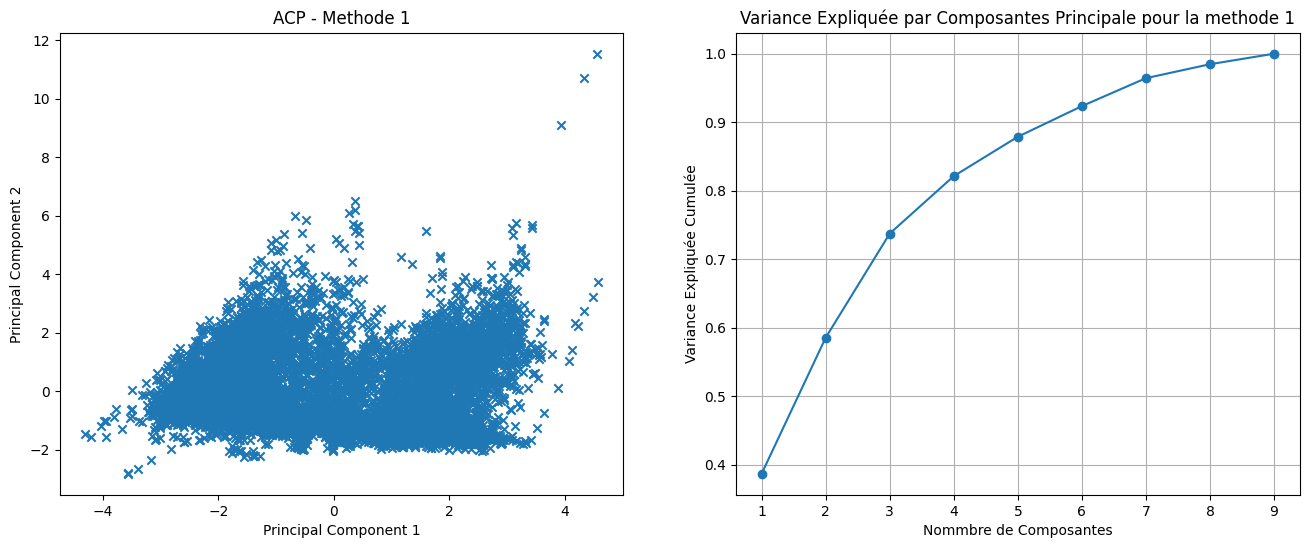

Methode 2
Variance expliquée : [0.33086896 0.58166255 0.73117273 0.8316209  0.8904426  0.93288233
 0.96649278 0.98917283 1.        ]


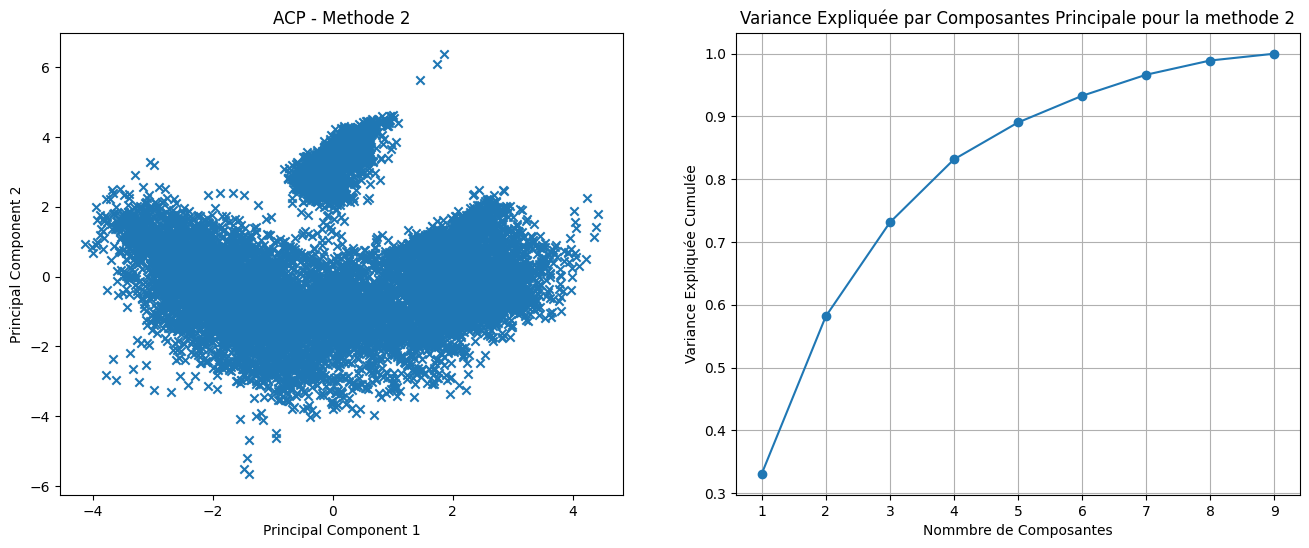

Methode 3
Variance expliquée : [0.32441833 0.55555418 0.74252433 0.85134201 0.9160974  0.95502148
 0.97984159 0.99432612 1.        ]


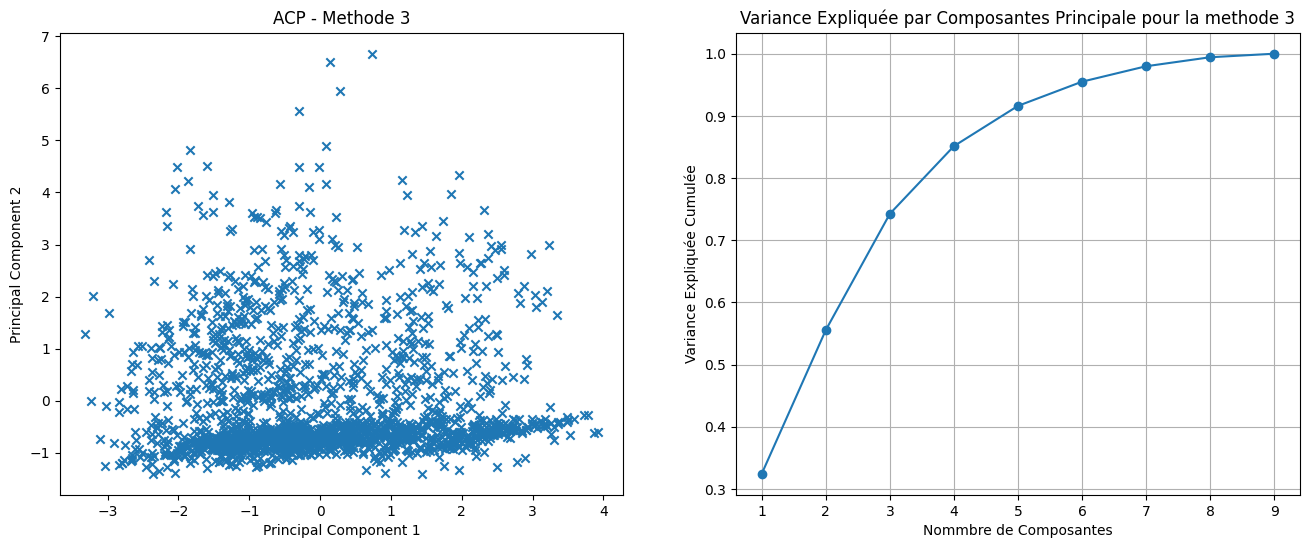

In [26]:
result_kmeans = []
for i,method in enumerate(methods):
    X_train_method,y_train_method=method
    # PCA pour la réduction de dimensions
    pca = PCA() #Pour affichage graphique
    x_train_pca = pca.fit_transform(X_train_method)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f"Methode {i+1}\nVariance expliquée : {cumulative_variance}")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    # Visualisation des clusters
    axes[0].scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1],marker="x")
    axes[0].set_title(f"ACP - Methode {i+1}")
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')

    # Visualisation de l'évolution de la variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axes[1].set_xlabel('Nommbre de Composantes')
    axes[1].set_ylabel('Variance Expliquée Cumulée')
    axes[1].set_title(f'Variance Expliquée par Composantes Principale pour la methode {i+1}')
    axes[1].grid(True)
    plt.show()
   

Observations :
* La courbe montre une augmentation de la variance expliquée avec les premières composantes donc elles capturent une partie importantes des informations.
* L'ajout de nouvelles composantes contribue de moins en moins à l'augmentation de la variance expliquée.

### 5.2) Kmeans

#### 5.2.1) Ajout de Features

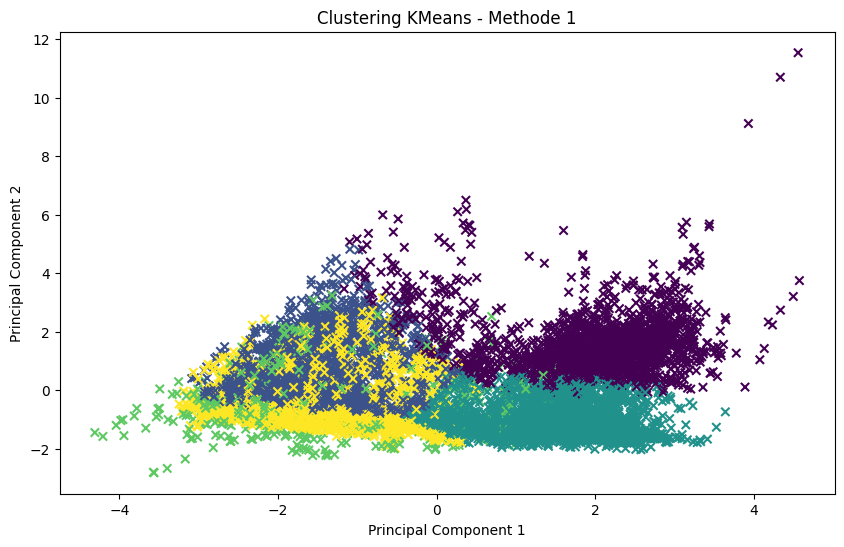

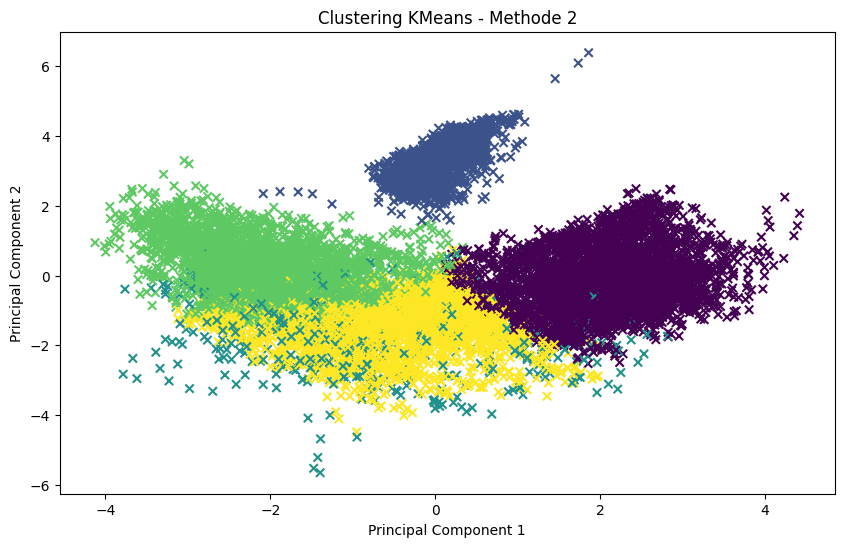

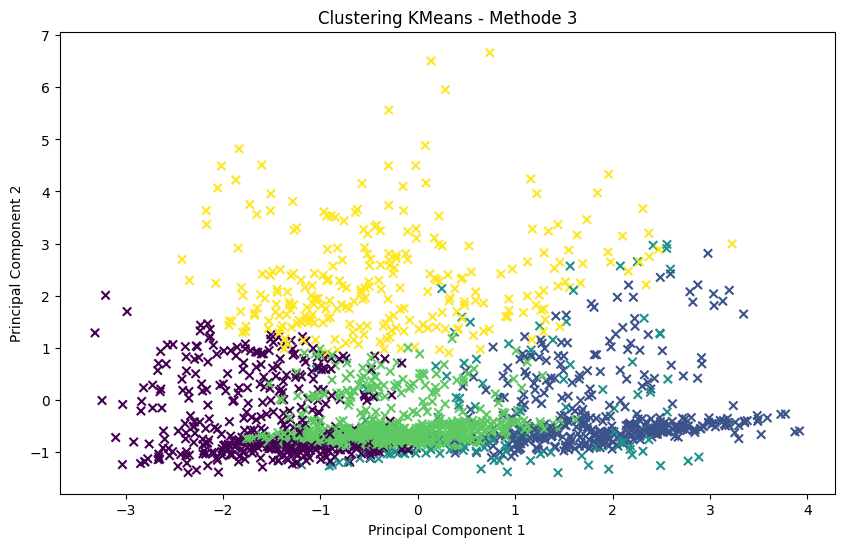

In [27]:
methods_features = []
result_kmeans = []
for i,method in enumerate(methods):
    X_train_method,y_train_method=method
    # PCA pour la réduction de dimensions
    pca = PCA(n_components=5)
    x_train_pca = pca.fit_transform(X_train_method)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(x_train_pca)
    clusters = kmeans.predict(x_train_pca)

    # Visualisation des clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x=x_train_pca[:, 0], y=x_train_pca[:, 1], c=clusters, marker= 'x', cmap='viridis')
    plt.title(f"Clustering KMeans - Methode {i+1}")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, ax=axes[1], label='Cluster Label')
    plt.show()

    # ajout des centroids et cluster aux données existantes
    clusters = pd.DataFrame(clusters,index=X_train_method.index,columns=['cluster'])
    centroids = kmeans.cluster_centers_
    for i,c in enumerate(centroids) :
        for j in range(len(c)):
            clusters.loc[clusters.cluster==i,f'cluster_{j}'] = c[j]
    methods_features.append((pd.concat([X_train_method,clusters],axis=1),y_train_method))

Nouvelles données

In [28]:
print(methods_features[0][0].info())
methods_features[0][0].describe()

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2022-01-01 02:00:00+01:00 to 2023-03-29 23:00:00+02:00
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   load_forecast                  10605 non-null  float64
 1   coal_power_available           10605 non-null  float64
 2   gas_power_available            10605 non-null  float64
 3   nucelear_power_available       10605 non-null  float64
 4   wind_power_forecasts_average   10605 non-null  float64
 5   solar_power_forecasts_average  10605 non-null  float64
 6   wind_power_forecasts_std       10605 non-null  float64
 7   solar_power_forecasts_std      10605 non-null  float64
 8   predicted_spot_price           10605 non-null  float64
 9   cluster                        10605 non-null  int32  
 10  cluster_0                      10605 non-null  float64
 11  cluster_1                      10605 non-null  float64
 12  cluster

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
count,1.060500e+04,1.060500e+04,1.060500e+04,1.060500e+04,1.060500e+04,1.060500e+04,1.060500e+04,1.060500e+04,1.060500e+04,10605.000000,10605.000000,10605.000000,10605.000000,10605.000000,10605.000000
mean,-2.894432e-16,-5.360058e-16,-1.114892e-15,4.716851e-16,-4.288047e-17,1.072012e-17,-1.072012e-16,-8.844096e-17,1.457320e-17,1.718906,0.000023,-0.000253,0.000464,-0.000386,-0.000125
std,9.374033e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.989149e-01,9.989149e-01,9.989149e-01,9.989149e-01,4.172352e-01,1.279170,1.590025,0.949308,0.835239,0.561487,0.164061
min,-2.058806e+00,-2.370892e+00,-3.502074e+00,-1.720369e+00,-1.170703e+00,-7.090499e-01,-9.350917e-01,-5.802288e-01,-2.884871e+00,0.000000,-1.594115,-1.045144,-0.849466,-1.055092,-0.336163
25%,-6.629772e-01,-1.199364e+00,-6.681200e-01,-8.384166e-01,-7.386672e-01,-7.090499e-01,-5.938474e-01,-5.802288e-01,1.539638e-17,1.000000,-1.594115,-1.045144,-0.849466,-0.056041,-0.066523
50%,-2.806179e-16,-2.783709e-02,4.915356e-02,-3.836600e-01,-3.547019e-01,-6.525263e-01,-2.901671e-01,-4.975623e-01,1.539638e-17,2.000000,-1.503132,-0.421917,-0.246087,0.057250,0.075865
75%,6.074256e-01,1.143690e+00,9.958720e-01,1.005546e+00,4.272616e-01,5.828646e-01,2.244745e-01,2.328416e-01,1.539638e-17,2.000000,1.403394,0.472246,0.387659,0.309336,0.106094
max,2.787033e+00,1.153790e+00,1.033079e+00,1.933039e+00,3.181003e+00,3.032219e+00,1.321390e+01,1.671847e+01,3.359548e+00,4.000000,1.940772,1.576931,2.608880,1.454267,0.231273


#### 5.2.2) Prediction après clustering

In [29]:
result_kmeans = []
for i,method in enumerate(methods):
    X_train_method,y_train_method=method
    # PCA pour la réduction de dimensions
    pca = PCA()
    x_train_pca = pca.fit_transform(X_train_method)
    x_train_pca = pd.DataFrame(x_train_pca,index=X_train_method.index)

    # KMeans Clustering
    kmeans = KMeans(n_clusters=20, random_state=42)
    kmeans.fit(x_train_pca)
    x_train_pca['cluster'] = kmeans.predict(x_train_pca)

    # Compute y_pred as means of cluster for training
    x_train_pca = pd.concat([x_train_pca,y_train_method],axis=1)
    groups = x_train_pca.groupby(by='cluster')
    map_y = {}
    for nb,group in groups:
        map_y[nb] = group.spot_id_delta.mean()
    x_train_pca['y_pred'] = x_train_pca['cluster'].apply(lambda x : map_y[x])

    # compute metrics
    w_acc = weighted_accuracy(y_train_method["spot_id_delta"],x_train_pca['y_pred'])
    result_kmeans.append([f"Methode_{i+1}",20,w_acc,kmeans,map_y,pca])
result_kmeans=pd.DataFrame(result_kmeans,columns=['Methode','nb_composante','W_Accuracy','Model','Map','PCA'])

In [30]:
result_kmeans

,Methode,nb_composante,W_Accuracy,Model,Map,PCA
0,Methode_1,20,0.574490,"KMeans(n_clusters=20, random_state=42)","{0: 1.2306809135975916, 1: -0.4211492661761095...",PCA()
1,Methode_2,20,0.563144,"KMeans(n_clusters=20, random_state=42)","{0: -7.180642502366376, 1: -1.4716162321557622...",PCA()
2,Methode_3,20,0.706544,"KMeans(n_clusters=20, random_state=42)","{0: 5.6516482800515595, 1: 5.585432420855427, ...",PCA()


Test sur X_test

La methode 3 est celle qui à la weighted accuracy la plus importante. Nous allons donc essayer avec ce set de données.

In [31]:
model = result_kmeans.Model.iloc[-1]
map_y = result_kmeans.Map.iloc[-1]
pca = result_kmeans.PCA.iloc[-1]
X_test_Kmeans = X_test_3.copy()
X_test_Kmeans = pd.DataFrame(pca.transform(X_test_Kmeans),index=X_test_Kmeans.index)
X_test_Kmeans['cluster'] = kmeans.predict(X_test_Kmeans)
X_test_Kmeans['y_pred'] = X_test_Kmeans['cluster'].apply(lambda x : map_y[x])
y_test_Kmeans = X_test_Kmeans[['y_pred']]
y_test_Kmeans

,y_pred
DELIVERY_START,
2023-04-02 00:00:00+02:00,7.030402
2023-04-02 01:00:00+02:00,7.030402
2023-04-02 02:00:00+02:00,7.030402
2023-04-02 03:00:00+02:00,7.030402
2023-04-02 04:00:00+02:00,7.030402
...,...
2023-10-24 19:00:00+02:00,-2.483788
2023-10-24 20:00:00+02:00,-2.483788
2023-10-24 21:00:00+02:00,8.160763


In [96]:
y_test_Kmeans.to_csv('y_test_Kmeans.csv')

## 6) Modèle supervisé

### 6.1) Classification

In [113]:
# Modèles SVM et RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


Il faut discretiser y_train. On peut utiliser une conversion en entier relatif (avec le signe)

In [106]:
y_train_cluster_1 = y_train_1.astype(int)
y_train_cluster_2 = y_train_2.astype(int)
y_train_cluster_3 = y_train_3.astype(int)
y_train_cluster_int = [y_train_cluster_1['spot_id_delta'],y_train_cluster_2['spot_id_delta'],y_train_cluster_3['spot_id_delta']]

In [ ]:
methods_features[0][1]

In [111]:
result_supervised = []
for i,method in enumerate(methods):
    # Split
    X_train_method,y_train_method=method
    y_train_method = y_train_cluster_int[i]
    X_train_method_train, X_train_method_test, y_train_method_train, y_train_method_test = sk.model_selection.train_test_split(X_train_method, y_train_method, test_size=0.2, random_state=42)
    
    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_method_train, y_train_method_train)
    y_pred_rf = pd.Series(rf_model.predict(X_train_method_test),index=y_train_method_test.index)
    weighted_acc_rf = weighted_accuracy(y_train_method_test, y_pred_rf)
    result_supervised.append((f"Methode_{i+1}","RF",weighted_acc_rf,rf_model))
    
    # SVM
    svm_model = SVC(random_state=42)
    svm_model.fit(X_train_method_train, y_train_method_train)
    y_pred_svm = svm_model.predict(X_train_method_test)
    weighted_acc_svm = weighted_accuracy(y_train_method_test, y_pred_svm)
    result_supervised.append((f"Methode_{i+1}","SVM",weighted_acc_svm,svm_model))

    # KNN
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_method_train, y_train_method_train)
    y_pred_knn = knn_model.predict(X_train_method_test)
    weighted_acc_knn = weighted_accuracy(y_train_method_test, y_pred_knn)
    result_supervised.append((f"Methode_{i+1}","KNN",weighted_acc_knn,knn_model))

    # Comparaison des performances
    #print("Random Forest Weighted Accuracy:", weighted_acc_rf)
    #print("SVM Weighted Accuracy:", weighted_acc_svm)
result_supervised=pd.DataFrame(result_supervised,columns=[f"Methode_{i+1}","RF","W_Accuracy","Modele"])
result_supervised

,Methode_3,RF,W_Accuracy,Modele
0,Methode_1,RF,0.807036,"(DecisionTreeClassifier(max_features='auto', r..."
1,Methode_1,SVM,0.018129,SVC(random_state=42)
2,Methode_1,KNN,0.556411,KNeighborsClassifier()
3,Methode_1,GBM,0.024330,"(DecisionTreeClassifier(max_depth=1, random_st..."
4,Methode_2,RF,0.776058,"(DecisionTreeClassifier(max_features='auto', r..."
5,Methode_2,SVM,0.066992,SVC(random_state=42)
6,Methode_2,KNN,0.524938,KNeighborsClassifier()
7,Methode_2,GBM,0.014250,"(DecisionTreeClassifier(max_depth=1, random_st..."
8,Methode_3,RF,0.809232,"(DecisionTreeClassifier(max_features='auto', r..."
9,Methode_3,SVM,0.002805,SVC(random_state=42)


Avec nos resultats, le modèle de Random Forest avec la methode de données 3 parait la plus performante. Nous allons donc retenir ces choix et faire une optimisation des hyperparamètres afin de trouver le modèle le plus performant.

In [115]:
X_train_3_train, X_train_3_test, y_train_3_train, y_train_3_test = sk.model_selection.train_test_split(X_train_3, y_train_3, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans la forêt
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer à chaque division
    'max_depth': [None, 10, 15],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5],  # Nombre minimum de données nécessaires pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum de données requises à chaque feuille
}

rf = RandomForestClassifier(random_state=42)
grid_search = sk.model_selection.GridSearchCV(estimator=rf, param_grid=param_grid,scoring=custom_score, cv=3, n_jobs=None, verbose=0)
grid_search.fit(X_train_3_train, y_train_3_train.astype(int))
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)

Meilleurs paramètres trouvés :  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
best_rf = grid_search.best_estimator_
#model = result_supervised.Modele.iloc[-2]
pred = best_rf.predict(X_train_3_test)
weighted_acc = weighted_accuracy(y_train_3_test['spot_id_delta'], pred)
weighted_acc

0.7831223481253674

In [ ]:
#model.get_params()

On predit sur notre echantillon X_test

In [ ]:
y_test_final = best_rf.predict(X_test_3)
y_test_final = pd.DataFrame(y_test_final,index=X_test_3.index,columns=["spot_id_delta"])
y_test_final.to_csv("y_rfc.csv")

Sur la plateforme, nous obtenons 0,4781.

### Regression

In [ ]:
result=[]
for i,method in enumerate(methods):
    X_train_method,y_train_method = method
    # Transformation de la cible en binaire (positif/négatif)
    y_train_binary = (y_train_method['spot_id_delta'] > 0).astype(int)

    # Modèle baseline : Régression Logistique
    baseline_model = LogisticRegression(max_iter=1000, random_state=42)
    baseline_model.fit(X_train_method, y_train_binary)

    # Prédictions et évaluation
    y_pred_baseline = baseline_model.predict(X_train_method)
    baseline_accuracy = accuracy_score(y_train_binary, y_pred_baseline)

    weighted_acc_baseline = weighted_accuracy(y_train_method['spot_id_delta'], y_pred_baseline)
    result.append((f"Method_{i+1}",baseline_accuracy,weighted_acc_baseline,baseline_model))
    #print("Baseline Accuracy:", baseline_accuracy)
    #print("Baseline Weighted Accuracy:", weighted_acc_baseline)
    #print("Classification Report (Baseline):")
    #print(classification_report(y_train_binary, y_pred_baseline))
result = pd.DataFrame(result,columns=["Methode","Accuracy","W_Accuracy","Modele"])
result

,Methode,Accuracy,W_Accuracy,Modele
0,Method_1,0.520038,0.326305,"LogisticRegression(max_iter=1000, random_state..."
1,Method_2,0.521501,0.293889,"LogisticRegression(max_iter=1000, random_state..."
2,Method_3,0.618093,0.571128,"LogisticRegression(max_iter=1000, random_state..."


## 7) Intérprétation des modèles 

Interpretation de l'importances des variables explicatives

In [32]:
# Get feature importances from the model
feature_importances = pd.DataFrame({
    'Feature': X_train_3.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importances

NameError: name 'best_rf' is not defined

Interpretation détaillée

In [ ]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train_3)

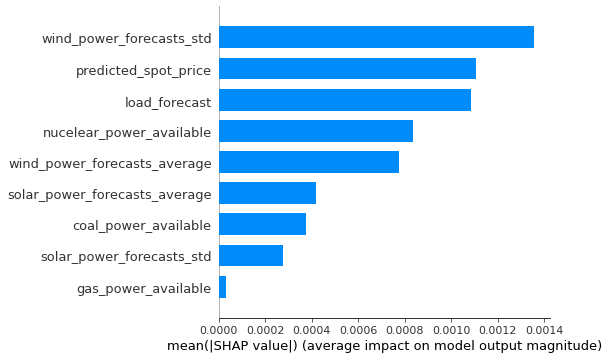

In [ ]:
class_index = 23
shap.summary_plot(shap_values[:, :, class_index], X_train_3, plot_type="bar")


In [ ]:
from IPython.display import HTML

style = """
<style>
    .lime, .lime * {
        background-color: #BBD;
        color: black;
    }
</style>
"""
HTML(style)


In [ ]:
import lime
import lime.lime_tabular


# Initialiser l'expliqueur LIME pour les données tabulaires
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_3.values,
    feature_names=X_train_3.columns,
    class_names=['spot_id_delta'],
    mode='regression'
)

# Choisissez une instance spécifique que vous souhaitez expliquer
i = 23  # index de l'instance dans X_train_imputed
exp = explainer.explain_instance(
    data_row=X_train_3.iloc[i].values, 
    predict_fn=best_rf.predict
)

# Afficher l'explication
exp.show_in_notebook(show_table=True, show_all=False)


## 8) Modèle de Deep Learning

In [46]:
X_train_3.to_csv("X_train_3.csv")
y_train_3.to_csv("y_train_3.csv")
X_test_3.to_csv("X_test_3.csv")

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Création du modèle de Deep Learning
dl_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_2.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
dl_model.fit(X_train_3, y_train_3, epochs=20, batch_size=32, validation_split=0.2)

# Prédiction et évaluation
y_pred_dl = (dl_model.predict(X_train_3) > 0.5).astype(int)
y_pred_dl = y_pred_dl.flatten()
weighted_acc_dl = weighted_accuracy(y_train_3['spot_id_delta'], y_pred_dl)

print("Deep Learning Model Weighted Accuracy:", weighted_acc_dl)

Epoch 1/20
47/47 [==============================] - 1s 7ms/step - loss: -1.9729 - accuracy: 0.0000e+00 - val_loss: -1.0620 - val_accuracy: 0.0000e+00
Epoch 2/20
47/47 [==============================] - 0s 3ms/step - loss: -8.8978 - accuracy: 0.0000e+00 - val_loss: -9.8617 - val_accuracy: 0.0000e+00
Epoch 3/20
47/47 [==============================] - 0s 3ms/step - loss: -26.6852 - accuracy: 0.0000e+00 - val_loss: -30.3548 - val_accuracy: 0.0000e+00
Epoch 4/20
47/47 [==============================] - 0s 5ms/step - loss: -64.6976 - accuracy: 0.0000e+00 - val_loss: -69.2621 - val_accuracy: 0.0000e+00
Epoch 5/20
47/47 [==============================] - 0s 4ms/step - loss: -149.1180 - accuracy: 0.0000e+00 - val_loss: -153.4062 - val_accuracy: 0.0000e+00
Epoch 6/20
47/47 [==============================] - 0s 2ms/step - loss: -284.4440 - accuracy: 0.0000e+00 - val_loss: -276.7260 - val_accuracy: 0.0000e+00
Epoch 7/20
47/47 [==============================] - 0s 4ms/step - loss: -480.4844 - accu

avec la metrique weigthed accuracy

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


# Définition de la métrique personnalisée
class WeightedAccuracy(Metric):
    def __init__(self, name="weighted_accuracy", **kwargs):
        super(WeightedAccuracy, self).__init__(name=name, **kwargs)
        self.total_weighted_accuracy = self.add_weight(name="total_weighted_accuracy", initializer="zeros")
        self.total_weight = self.add_weight(name="total_weight", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        correct_predictions = tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
        weights = tf.abs(y_true)
        weighted_correct_predictions = correct_predictions * weights
        self.total_weighted_accuracy.assign_add(tf.reduce_sum(weighted_correct_predictions))
        self.total_weight.assign_add(tf.reduce_sum(weights))

    def result(self):
        return self.total_weighted_accuracy / self.total_weight

    def reset_states(self):
        self.total_weighted_accuracy.assign(0)
        self.total_weight.assign(0)

# Construction du modèle
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_3.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Configuration du checkpoint pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint(
    'best_model.h5',          # nom du fichier où le modèle est sauvegardé
    monitor='val_weighted_accuracy',  # métrique à surveiller
    verbose=1,                # afficher des informations détaillées
    save_best_only=True,      # sauvegarder uniquement le meilleur modèle
    mode='max',               # maximiser la métrique
    save_weights_only=False   # sauvegarder l'architecture du modèle et les poids
)

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[WeightedAccuracy()])

# Entraînement du modèle
history = model.fit(X_train_3, y_train_3, epochs=20, batch_size=32, validation_split=0.2,callbacks=[checkpoint])

print("Weighted accuracy",history.history['weighted_accuracy'][-1])


Epoch 1/20
22/47 [=============>................] - ETA: 0s - loss: -0.2199 - weighted_accuracy: 0.2196    
Epoch 1: val_weighted_accuracy improved from -inf to 0.51347, saving model to best_model.h5
47/47 [==============================] - 1s 8ms/step - loss: -0.6237 - weighted_accuracy: 0.3304 - val_loss: -1.2403 - val_weighted_accuracy: 0.5135
Epoch 2/20
28/47 [================>.............] - ETA: 0s - loss: -2.7593 - weighted_accuracy: 0.5310
Epoch 2: val_weighted_accuracy improved from 0.51347 to 0.53984, saving model to best_model.h5
47/47 [==============================] - 0s 4ms/step - loss: -4.9526 - weighted_accuracy: 0.5466 - val_loss: -5.8850 - val_weighted_accuracy: 0.5398
Epoch 3/20
28/47 [================>.............] - ETA: 0s - loss: -13.0724 - weighted_accuracy: 0.5377
Epoch 3: val_weighted_accuracy did not improve from 0.53984
47/47 [==============================] - 0s 3ms/step - loss: -13.7653 - weighted_accuracy: 0.5319 - val_loss: -9.2635 - val_weighted_accur

AttributeError: 'History' object has no attribute 'best_model'

In [43]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class WeightedAccuracy(Metric):
    def __init__(self, name="weighted_accuracy", **kwargs):
        super(WeightedAccuracy, self).__init__(name=name, **kwargs)
        self.total_weighted_accuracy = self.add_weight(name="total_weighted_accuracy", initializer="zeros")
        self.total_weight = self.add_weight(name="total_weight", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
        correct_predictions = tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32)
        weights = tf.abs(y_true)

        weighted_correct_predictions = correct_predictions * weights

        self.total_weighted_accuracy.assign_add(tf.reduce_sum(weighted_correct_predictions))
        self.total_weight.assign_add(tf.reduce_sum(weights))

    def result(self):
        return self.total_weighted_accuracy / self.total_weight

    def reset_states(self):
        self.total_weighted_accuracy.assign(0)
        self.total_weight.assign(0)


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Création du modèle de Deep Learning
dl_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_2.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[WeightedAccuracy()])

# Entraînement du modèle
dl_model.fit(X_train_3, y_train_3, epochs=20, batch_size=32, validation_split=0.2)

# Prédiction et évaluation
y_pred_dl = (dl_model.predict(X_train_3) > 0.5).astype(int)
y_pred_dl = y_pred_dl.flatten()
weighted_acc_dl = weighted_accuracy(y_train_3['spot_id_delta'], y_pred_dl)

print("Deep Learning Model Weighted Accuracy:", weighted_acc_dl)

Epoch 1/20
47/47 [==============================] - 1s 6ms/step - loss: -0.0394 - weighted_accuracy: 0.1017 - val_loss: 5.4107 - val_weighted_accuracy: 0.1912
Epoch 2/20
47/47 [==============================] - 0s 3ms/step - loss: -3.7999 - weighted_accuracy: 0.4126 - val_loss: 7.6666 - val_weighted_accuracy: 0.2581
Epoch 3/20
47/47 [==============================] - 0s 3ms/step - loss: -10.5950 - weighted_accuracy: 0.4663 - val_loss: 14.4238 - val_weighted_accuracy: 0.2845
Epoch 4/20
47/47 [==============================] - 0s 3ms/step - loss: -25.0067 - weighted_accuracy: 0.4852 - val_loss: 13.3049 - val_weighted_accuracy: 0.3269
Epoch 5/20
47/47 [==============================] - 0s 2ms/step - loss: -54.4972 - weighted_accuracy: 0.4961 - val_loss: 30.0219 - val_weighted_accuracy: 0.3172
Epoch 6/20
47/47 [==============================] - 0s 3ms/step - loss: -109.9061 - weighted_accuracy: 0.4975 - val_loss: 29.8897 - val_weighted_accuracy: 0.3315
Epoch 7/20
47/47 [===================

### Modèle LSTM

#### Formatage

In [ ]:
# Function to create sequences for LSTM model
def create_sequences(data, target, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(target[i + sequence_length])
    return np.array(xs), np.array(ys)

# Define the sequence length (number of time steps)
sequence_length = 24  # for example, using 24 hours of data to predict the next hour

# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(X_train_2, y_train_2['spot_id_delta'].values, sequence_length)

# Display the shape of the prepared data
X_train_seq.shape, y_train_seq.shape


#### Création et entrainement du modèle

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=10, validation_split=0.2, verbose=1, batch_size=32)


#### Prediction de X_test

In [ ]:
X_test_seq = create_sequences(X_test_2, np.zeros(len(X_test_2)), sequence_length)
y_test_LSTM = model.predict(X_test_seq)
y_test_LSTM

In [ ]:
y_test_LSTM = y_test_LSTM.to_csv('y_test_LSTM.csv')

## 9) Comparaison des résultats

In [ ]:
# Comparaison des modèles
model_performance = {
    'Baseline (Logistic Regression)': weighted_acc_baseline,
    'Random Forest': weighted_acc_rf,
    'SVM': weighted_acc_svm,
    #'Deep Learning': weighted_acc_dl
}

for model, score in model_performance.items():
    print(f"{model}: {score:.4f}")

Baseline (Logistic Regression): 0.3263
Random Forest: 0.5204
SVM: 0.2908
